# Amazon Reviews Sentiment Modeling 


<b>Author:</b> Przemyslaw Niedziela (przemyslaw.niedziela98@gmail.com) <br> 
<b>Date:</b> Nov 2024 <br>
<br> <br> 

TL;DR <br>
This project uses DistilBERT to calculate sentiment scores and determine optimal score thresholds for product sentiment classification. Two deep learning models are employed: a sequential LSTM model and a more advanced model with convolutional layers, batch normalization and pooling. The results show good performance. Sentiment ranks for products were calculated based on aggregated sentiment scores.

<br> <br> 
Table of contents: 
1. [Data preprocessing](#data-preprocessing)
2. [Labeling](#using-pre-trained-model-for-labels)
3. [Inirial model](#initial-model)
4. [Model](#model-with-cnn-and-bilstm)
5. [Product analysis](#product-analysis)

In [2]:
import warnings
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, LSTM, Bidirectional, GlobalMaxPooling1D, Dropout, Conv1D, MaxPooling1D, BatchNormalization
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from transformers import pipeline

warnings.filterwarnings('ignore')

In [3]:
DATASET_PATH = "/Users/przemyslawniedziela/.cache/kagglehub/datasets/arhamrumi/amazon-product-reviews/versions/1/Reviews.csv"

CONTRACTIONS = {
    "n't": " not", "'re": " are", "'s": " is", "'d": " would", "'ll": " will",
    "'t": " not", "'ve": " have", "'m": " am"
}

### Data Preprocessing 

Expanding contractions, removing stopwords, lammatization and tokenization.

In [4]:
dataset = pd.read_csv(DATASET_PATH, index_col = [0])
dataset_subset = dataset.sample(int(1e5))

In [5]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [6]:
def expand_contractions(text):
    """Expand common contractions in text."""
    for contraction, expanded in CONTRACTIONS.items():
        text = re.sub(contraction, expanded, text)
    return text

def preprocess_text(text):
    """
    Preprocess the input text by cleaning, normalizing, and tokenizing.

    - Convert text to lowercase.
    - Expand contractions.
    - Remove punctuation and special characters.
    - Remove numbers.
    - Remove stopwords.
    - Lemmatize the tokens to their base forms.
    """
    text = expand_contractions(text.lower())
    text = re.sub(r'[^a-z\s]', '', text) 
    tokens = word_tokenize(text)  
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]    
    return ' '.join(tokens)

text_data = dataset_subset['Text'].apply(preprocess_text)
tokenizer = Tokenizer(num_words=20000)  
tokenizer.fit_on_texts(text_data)
sequences = tokenizer.texts_to_sequences(text_data)
word_index = tokenizer.word_index

data = pad_sequences(sequences, maxlen=100)

### Using pre-trained model for labels  
Fitting a DistilBERT base uncased model fine-tuned on SST-2 for sentiment analysis using Hugging Face, determining the score threshold that achieves the highest F1-score and creating labels based on that threshold for a custom model.

In [7]:
def generate_sentiment_labels_pretrained(text_data):
    """
    Generates sentiment labels for a list of text data using a pre-trained sentiment analysis model.
    """

    sentiment_analyzer = pipeline("sentiment-analysis", 
                                model="distilbert-base-uncased-finetuned-sst-2-english")

    sentiment_labels = []
    for text in text_data:
        result = sentiment_analyzer(text[:512])
        sentiment = result[0]['label']
        sentiment_labels.append(1 if sentiment == "POSITIVE" else 0)

    return np.array(sentiment_labels)

pseudo_labels = generate_sentiment_labels_pretrained(text_data)


In [8]:
def analyze_correlation_and_find_threshold(dataset_subset, pseudo_labels):
    """
    Analyzes the correlation between sentiment labels and scores and determines the optimal threshold 
    for binarizing the scores.
    """
    scores = dataset_subset['Score'].values
    correlation_pearson = np.corrcoef(scores, pseudo_labels)[0, 1]
    correlation_spearman = pd.Series(scores).corr(pd.Series(pseudo_labels), method='spearman')
    
    best_f1, best_threshold = 0, None
    thresholds = np.arange(1, 11) 

    for threshold in thresholds:
        binary_labels = (scores >= threshold).astype(int)
        current_f1 = f1_score(binary_labels, pseudo_labels)
        
        if current_f1 > best_f1:
            best_f1 = current_f1
            best_threshold = threshold
    
    return {
        'pearson_correlation': correlation_pearson,
        'spearman_correlation': correlation_spearman,
        'best_threshold': best_threshold,
        'best_f1_score': best_f1
    }


results = analyze_correlation_and_find_threshold(dataset_subset, pseudo_labels)
print(f"Pearson Correlation: {results['pearson_correlation']}")
print(f"Spearman Correlation: {results['spearman_correlation']}")
print(f"Best Threshold: {results['best_threshold']} (F1-Score: {results['best_f1_score']})")


Pearson Correlation: 0.364572991268317
Spearman Correlation: 0.34611229952968814
Best Threshold: 4 (F1-Score: 0.7124818256526961)


In [9]:
labels = (dataset_subset['Score'] >= 4).astype(int).values

### Initial model 

Sequential model with: <br>
- embedding layer for text input; <br>
- bidirectional LSTM for capturing contextual relationships; <br>
- global max pooling for feature extraction; <br>
-  dense layers with dropout; <br>

In [10]:
def create_model(vocab_size, max_seq_len):
    inputs = Input(shape=(max_seq_len,))
    x = Embedding(input_dim=vocab_size, output_dim=128, input_length=max_seq_len)(inputs)
    x = Bidirectional(LSTM(64, return_sequences=True))(x)
    x = GlobalMaxPooling1D()(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x) 

    return Model(inputs=inputs, outputs=outputs)


model = create_model(min(len(word_index) + 1, 20000), 100)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 100, 128)       │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 100, 128)       │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,667,137 (10.17 MB)

 Trainable params: 2,667,137 (10.17 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
labels_train = np.array(labels)

X_train, X_test, y_train, y_test = train_test_split(data, labels_train, test_size=0.2, random_state=42)
history = model.fit(X_train, y_train, batch_size=32, epochs=6, validation_split=0.2)

Epoch 1/6
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 131s 64ms/step - accuracy: 0.8309 - loss: 0.3880 - val_accuracy: 0.8844 - val_loss: 0.2751
Epoch 2/6
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 123s 62ms/step - accuracy: 0.9097 - loss: 0.2274 - val_accuracy: 0.8896 - val_loss: 0.2699
Epoch 3/6
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 120s 60ms/step - accuracy: 0.9378 - loss: 0.1630 - val_accuracy: 0.8878 - val_loss: 0.2941
Epoch 4/6
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 116s 58ms/step - accuracy: 0.9554 - loss: 0.1184 - val_accuracy: 0.8846 - val_loss: 0.3270
Epoch 5/6
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 114s 57ms/step - accuracy: 0.9713 - loss: 0.0809 - val_accuracy: 0.8850 - val_loss: 0.3675
Epoch 6/6
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 115s 58ms/step - accuracy: 0.9803 - loss: 0.0600 - val_accuracy: 0.8866 - val_loss: 0.5133


In [12]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.8850 - loss: 0.5263
Test Loss: 0.5341
Test Accuracy: 0.8836


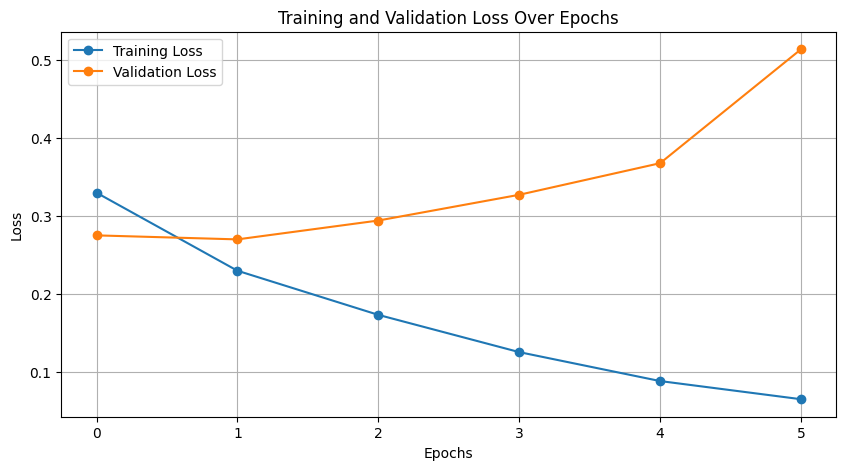

In [13]:
training_loss = history.history['loss']
validation_loss = history.history.get('val_loss')

plt.figure(figsize=(10, 5))
plt.plot(training_loss, label='Training Loss', marker='o')
if validation_loss is not None:
    plt.plot(validation_loss, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step


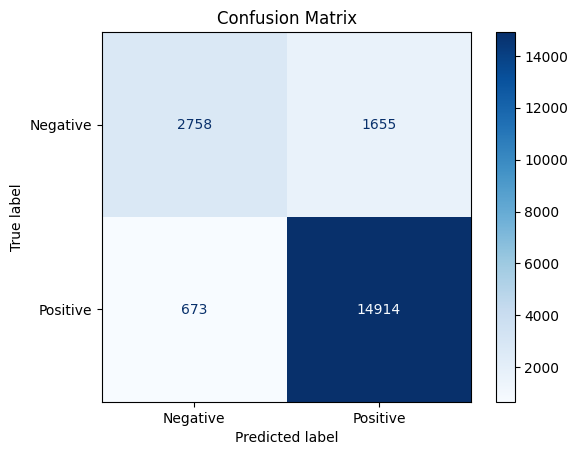

In [14]:
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob >= 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])

disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

In [15]:
new_texts = dataset.sample(10)
text_data = new_texts['Text'].apply(preprocess_text)
new_sequences = tokenizer.texts_to_sequences(text_data)
new_data = pad_sequences(new_sequences, maxlen=100)

predictions = model.predict(new_data)
predicted_labels = (predictions > 0.5).astype(int)
predicted_sentiment = ["POSITIVE" if label == 1 else "NEGATIVE" for label in predicted_labels.flatten()]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step


In [16]:
dict(zip(new_texts['Text'], predicted_sentiment))

{'I was not satisfied with these walnuts. The first time I ordered them, they were excellent. The second time I ordered them, they tasted very stale, almost burnt. Absolutely disgusting. Normally, if something is not up to par I will at least eat it to prevent wasting, but these were so bad that I threw them out and considered calling amazon for a return, although I never took the time to do that. I just made the decision never to order them again.': 'NEGATIVE',
 'This item had a great price and tastes great. The only thing that could make this product better is if the little plastic cup was recyclable or compostable.': 'POSITIVE',
 'It seems all of our friends and family are so used to microwave popcorn, that when we pop this, they start to ask lots of questions.  One of my friends "had" to go out and buy a larger machine than mine!  (It seems he always has to 1-up me)  In any case, this is the closest stuff to movie theater popcorn you can get, however I like it a bit better than the

### Model with CNN and BiLSTM
Model that includes embedding, Conv1D, batch normalization, max pooling, bidirectional LSTM, global max pooling, multiple dense layers, dropout, and a configurable output layer.

In [17]:
def create_bilstm_model(vocab_size, max_seq_len):
    inputs = Input(shape=(max_seq_len,))

    x = Embedding(input_dim=vocab_size, output_dim=128, input_length=max_seq_len)(inputs)
    x = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Bidirectional(LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))(x)
    x = GlobalMaxPooling1D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)  

    model = Model(inputs=inputs, outputs=outputs)
    return model

bilstm_model = create_bilstm_model(min(len(word_index) + 1, 20000), 100)
bilstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

bilstm_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 100, 128)       │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 100, 128)       │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 100, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 50, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,733,441 (10.43 MB)

 Trainable params: 2,733,185 (10.43 MB)

 Non-trainable params: 256 (1.00 KB)

In [18]:
history = bilstm_model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 85s 81ms/step - accuracy: 0.8366 - loss: 0.3860 - val_accuracy: 0.8829 - val_loss: 0.2841
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 81s 81ms/step - accuracy: 0.9154 - loss: 0.2140 - val_accuracy: 0.8928 - val_loss: 0.2653
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 81s 81ms/step - accuracy: 0.9484 - loss: 0.1416 - val_accuracy: 0.8924 - val_loss: 0.2848
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 81s 81ms/step - accuracy: 0.9700 - loss: 0.0859 - val_accuracy: 0.8952 - val_loss: 0.3583
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 81s 81ms/step - accuracy: 0.9807 - loss: 0.0528 - val_accuracy: 0.8841 - val_loss: 0.3962
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 81s 81ms/step - accuracy: 0.9869 - loss: 0.0376 - val_accuracy: 0.8854 - val_loss: 0.3985
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 82s 82ms/step - accuracy: 0.9897 - loss: 0.0305 - val_accuracy: 0.8859 - val_loss: 0.4893
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 82s 81ms/step - accuracy: 0.9922 -

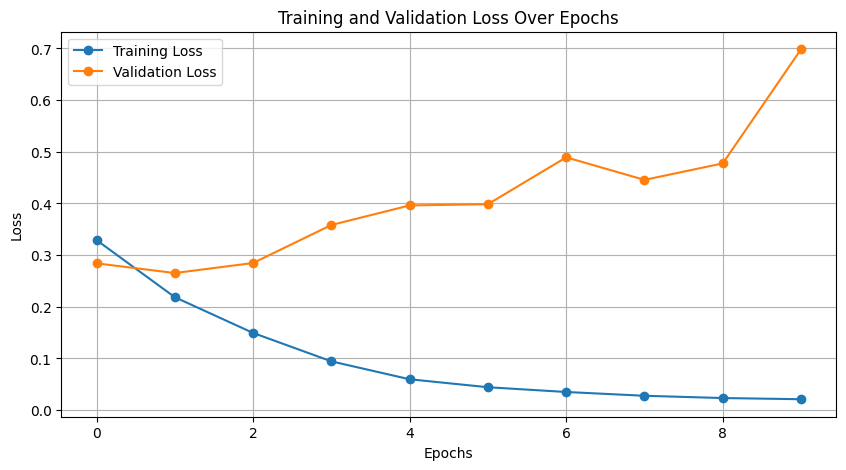

In [19]:
training_loss = history.history['loss']
validation_loss = history.history.get('val_loss')

plt.figure(figsize=(10, 5))
plt.plot(training_loss, label='Training Loss', marker='o')
if validation_loss is not None:
    plt.plot(validation_loss, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step


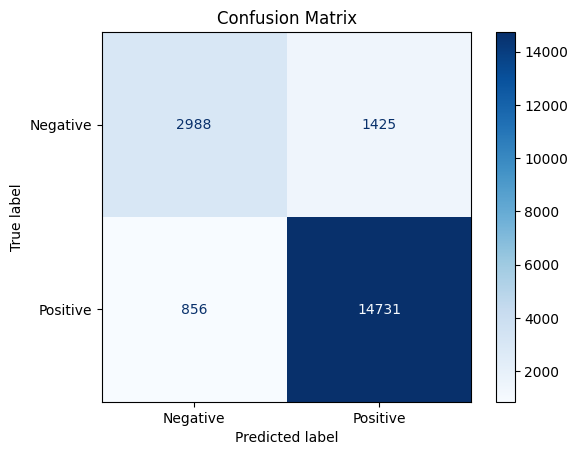

In [20]:
y_pred_prob = bilstm_model.predict(X_test)
y_pred = (y_pred_prob >= 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])

disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

### Product example analysis

Calculating sentiment rank by product 

In [21]:
product_dataset = dataset[dataset['ProductId'].isin(dataset['ProductId'].value_counts().head(100).index)]

In [22]:
product_data = product_dataset['Text'].apply(preprocess_text)
product_data_seq = pad_sequences(tokenizer.texts_to_sequences(product_data), maxlen=100)
predictions_product = bilstm_model.predict(product_data_seq)
product_dataset['label'] = (predictions_product > 0.5).astype(int).flatten()

1445/1445 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step


In [23]:
product_agg = product_dataset.groupby(by='ProductId').agg({
    'Time': 'count',
    'label': 'sum'
}).reset_index()
product_agg['sentiment_rank'] = product_agg['label'] / product_agg['Time']
product_agg = product_agg[['ProductId', 'sentiment_rank']].sort_values(by='sentiment_rank', ascending=False)

In [24]:
product_agg

,ProductId,sentiment_rank
11,B000NMJWZO,0.977860
88,B007JFMH8M,0.956188
25,B001E8DHPW,0.946015
5,B000GAT6NG,0.946015
67,B004EAGP74,0.946015
...,...,...
47,B003CIBPN8,0.651316
9,B000KV61FC,0.595324
10,B000KV7ZGQ,0.595324
82,B006MONQMC,0.586558
